# Descrete time Quantum walk on line or ring topology

## Instructions:

Follow the example from Bootcamp 4. For creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes.

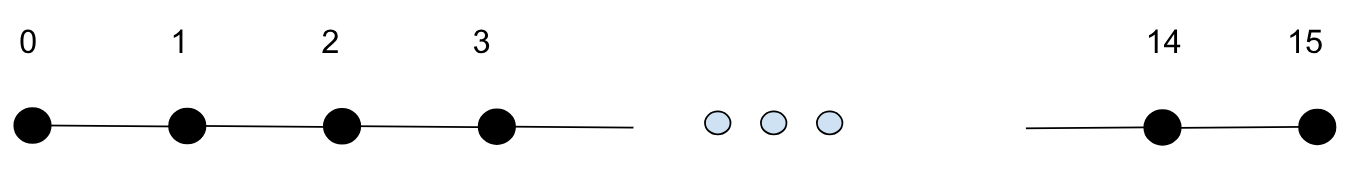

_Image credits: Womanium Quantum + AI Scholarip Program with Classiq on Canva_

# A little of theory


A quantum walk is the quantum vertion of a random walk, clasically a "walker" moves randomly throught a graph G. In quantum walks, the walker is governed by the laws of quantum mechanics so it can exist in a superposition state and move to more that one site at the time.

The graph G is compossed by a set of vertex V and a set of edges E. We will name the subset of edges that include some specific vertex $j$ as $E_{j}$. 

## Statates in a quantum walk

The states of a graph in a quantum walk lives in a Hilbert space compossed by states of the form $\vert j,k \rangle$ where the pair $(j,k)\in E$. This can be seen as if the walk takes place overthe edges instead of the vertex. The state $\vert j,k\rangle$ can be interpreted as a walker in the vertex $j$ that wants to travel to the vertex $k$. In this notebook we will name the different subspaces as walker and adj (in sort for adjacent vertex), so we can write the state $\vert j,k\rangle= \vert j\rangle_{walker}\otimes\vert k\rangle_{adj}.$

## Evolution in a discrete time quantum walk

In quantum walks, one step of the evolution is given by appling a unitary operator $U=SW$ that is composed by a coin operator $W$ and a shift (or swap) operator $S$. 

To easily understand this, lets assume that the initial state of the graph consist of a state $\vert j,k \rangle$ where the walker is in the vertex $j$. 

The coin operator $W$ (in this case the Grover difussor), will prepare the adj qubits into a superposition of all possible vertex in which the walker can evolve, that is, will prepare a stete that is a superposition of the edges in the subset $E_{j}$.  

Then, the swap operator $S$ will perform a literal swap between the superposition created in the adj qubits and the walker qubits, so the final state will consist of the walker living in a superposition of all the vertex that are adjecent to the vertex $j$ where it begins.   

# Implementation 

In this notebook we will take some liberties and make the program for a n node graph with either ring or line topology.  

In [1]:
from classiq import *

In [13]:
#The size variable gives us the number of qubits used for the network
#the number of nodes will be n=size^2
size = 4

#Here we decide what topology do we want for our graph
# 0 means a ring topology
# 1 means a line topology
topology=1

### The coin operator W

As mentioned before for this program the coin operator will be a Grover diffusor thath has the form

\begin{equation}
W= \sum_{j\in V} \vert j\rangle\langle j \vert_{walker} \otimes (2\vert \partial_{j}\rangle\langle \partial_{j}\vert-\mathbb{1})_{adj}
\end{equation}


In [14]:
#First a function to prepare a qubit in the minus state H|1>= (1\frac{2})(|0> - |1>)
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

#The oracle for the zero deiffuzer will turn the phase of the |0> state
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

#Now we define the zero diffuzer 
@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux), action=lambda: diffuzer_oracle)

#the W_iteration writes a matrix A, that is similar to what in graph theory is called an "adjacency matrix"
#which is a matrix where every row and every cloumn represents a vertex in such a way that 
#the element A(i,j) represents the probability that a walker in the vertex i 
#walks to the vertex j in the next step.
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    #We prepare a vector of n sites
    prob=[0]*(2**size)
    #If topoloty==1 then we write the matrix for a line topology
    if topology==1: 
        if i==2**size-1:
            prob[(i-1)%(2**size)]=1
        elif i==0:
            prob[(i+1)%(2**size)]=1
        else:
            prob[(i+1)% (2**size)]=0.5
            prob[(i-1)% (2**size)]=0.5
            
    #If tpology==0 then we write the matrix for a ring topology
    elif topology==0:  
        prob[(i+1)% (2**size)]=0.5
        prob[(i-1)% (2**size)]=0.5
    else: 
        print("you need to define a topology")
    
    #This print will shows os the matrix A       
    print(f'State={i}, prob vec ={prob}')
    #Now we will give use to the zero_diffuser and the rows of the matrix A to prepare the 
    #adj qubits into a superposition of the vertex that are adjacent to the vertex where the walker is
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

#Now the W_operator that applies the W_iteration checking every row of the matrix A 
#This is necesary since our quantum walker can be in a superposition of vertex
@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i,vertices,adjacent_vertices)




## The shift operator S

The shift operator has the form

\begin{equation}
S= \sum_{(j,k)\in E} \vert j\rangle_{walker} \vert k\rangle_{adj}\langle k\vert_{walker} \langle j \vert_{adj}
\end{equation}

In [15]:
#Here we deffine the oracle for the swapp function in both topologys
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    if topology==0:
        res |= (((vertices+adjacent_vertices)%2) ==1)
    elif topology==1:
        res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

        
#The function that literaly swaps the state of the walker with the adj
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len, iteration= lambda i: SWAP(x[i],y[i])) 
    
#the final S operator that will swap only if they are adjacent vertex
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1, operand= lambda: bitwise_swap(vertices,adjacent_vertices))



Finally we create a main function that prepares a state in a perfect superposition of all vertex, and runs the quantum walk one step. 

So te initial state will be

\begin{equation}
 \frac{1}{\sqrt{n}} \left(\sum_{n}\vert n \rangle_{walker}\right) \otimes \vert 0\rangle_{ajd}
\end{equation}

and we ended up with  the state 

\begin{equation}
 SW \left( \frac{1}{\sqrt{n}} \left(\sum_{n}\vert n \rangle_{walker}\right) \otimes \vert 0\rangle_{ajd} \right)
\end{equation}

In [19]:

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size,vertices) #Initialize the vertex qubits
    hadamard_transform(vertices) #Prepare a superposition of the vertex 
    allocate(size,adjacent_vertices) #Initialize the adj qubits
    
    W_operator(vertices,adjacent_vertices) #Applies the W or coin operator
    S_operator(vertices,adjacent_vertices) #Applies the Switch operator

qmod = create_model(main)
qprog = synthesize(qmod)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

In [20]:
#And of course the circuit
show(qprog)
write_qmod(create_model(main), "randomwalk")